# Chapter 4: Basics of Neural Networks

In [78]:
import numpy as np
import torch 
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import time
%matplotlib inline 

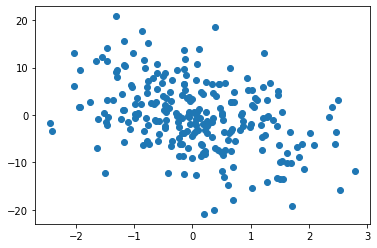

In [79]:
data = np.random.multivariate_normal([0,0],[[1,-3],[-3,52]],250)
X = torch.tensor(data[:,0]).type(torch.FloatTensor)
y = torch.tensor(data[:,1]).type(torch.FloatTensor)
plt.scatter(X,y)


## Linear model

We will focus on a linear model of the form $y = w_0 + w_1x + \epsilon$. Where $\epsilon$ is assumed to be gaussian noise with zero mean and variance $\sigma^2$.


**Analytic solution**

w: tensor([-0.0665, -2.7473])


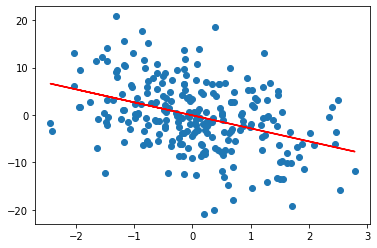

In [80]:
X_ = torch.cat((torch.ones(X.size()).unsqueeze(dim=1),X.unsqueeze(dim=1)),1)
w = torch.inverse(X_.T @ X_) @ X_.T @ y
print('w:',w)
plt.plot(X, X_ @ w,'r')
plt.scatter(X,y)

### Gradient descent
**Gradient descent with pytorch autograd**

In [81]:
def r_emp(w,X,y):
     return (y - X @ w).T @ (y - X @ w)

In [82]:
def min_r_emp_1(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1],requires_grad=True)
    
    for i in range(k):
        if w.grad is not None:
            w.grad.zero_()
        l_p = r_emp(w,X,y)
        l_p.backward()
        w = (w - lr*w.grad).detach().requires_grad_()
    return w

In [83]:
w_g = min_r_emp_1(X_,y)
print('Solution: ',w_g)

Solution:  tensor([-0.0665, -2.7473], requires_grad=True)


**Gradient descent with pytorch autograd and optimizer**

In [84]:
def min_r_emp_2(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1],requires_grad=True)
    optimizer = optim.SGD([w],lr=lr)
    
    for i in range(k):
        l_p = r_emp(w,X,y)
        optimizer.zero_grad()
        l_p.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l_p))
    return w

In [85]:
w_g_2 = min_r_emp_2(X_,y,lr=0.001,k=500)
print('Solution:',w_g_2)

Epoch 0, Loss 15216.939453
Epoch 100, Loss 11179.502930
Epoch 200, Loss 11179.502930
Epoch 300, Loss 11179.502930
Epoch 400, Loss 11179.502930
Solution: tensor([-0.0665, -2.7473], requires_grad=True)


**Gradient descent with manual differentiation**

In [86]:
def dw_r_emp(w,X,y):
    return X.T @ (X @ w - y)

In [87]:
def min_r_emp_3(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1])
    
    for i in range(k):
        l_p = r_emp(w,X,y)
        dw = dw_r_emp(w,X,y)
        w = (w - lr*dw)
    return w

In [88]:
w_g_3 = min_r_emp_3(X_,y,lr=0.001,k=500)
print('Solution:',w_g_3)

Solution: tensor([-0.0665, -2.7473])


Define a general training loop

In [89]:
def training_loop(X,y,w,optimizer,model,loss_fn,lr=1e-3,n_epochs=5000):
   
    for i in range(n_epochs):
        y_p = model(w,X)
        loss = loss_fn(y_p,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print('Epoch %d, Loss %f' % (i,loss))

    print('Result:',w)
    return w

In [90]:
def model(w,X):
    return X @ w

def loss_fn(y_p,y):
    return 0.5*((y_p - y)**2).sum()

In [91]:
w = torch.ones(X_.shape[1],requires_grad=True)
optimizer = optim.SGD([w],lr=1e-3)

training_loop(X_,y,w,optimizer,model,nn.MSELoss())

Epoch 0, Loss 60.867760
Epoch 500, Loss 46.637276
Epoch 1000, Loss 44.947449
Epoch 1500, Loss 44.745628
Epoch 2000, Loss 44.721363
Epoch 2500, Loss 44.718422
Epoch 3000, Loss 44.718063
Epoch 3500, Loss 44.718021
Epoch 4000, Loss 44.718010
Epoch 4500, Loss 44.718010
Result: tensor([-0.0665, -2.7472], requires_grad=True)


tensor([-0.0665, -2.7472], requires_grad=True)

## Linear neuron with activation

### Sigmoid

generate 2-D testdata

C:\Users\dohr\AppData\Local\Temp\ipykernel_14896\4048414768.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)


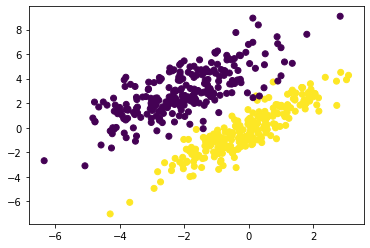

In [92]:
X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)
X2 = torch.tensor(np.random.multivariate_normal([-2,3],[[2,2],[2,4]],250)).type(torch.FloatTensor)
X = torch.cat((X1,X2),0)
y = torch.cat((torch.ones(250),torch.zeros(250)),0)

plt.scatter(X[:,0],X[:,1],c=y)

In [93]:
def model_sigmoid(X,w,bias=True):
    x_temp = torch.cat((torch.ones(X.shape[0]).unsqueeze(dim=1),X),dim=1)
    return torch.sigmoid(x_temp @ w)

In [94]:
def loss_sigmoid(y_p,y):
    r = -torch.log(y_p)*y - (1-y)*torch.log(1-y_p)
    return r.sum()

In [95]:
def train_loop_sigmdoid(X,y,lr=1e-4,n_epoch=500):
    w = torch.ones(3,requires_grad=True)
   # print(w)
    for i in range(n_epoch):
        if w.grad is not None:
            w.grad.zero_()

        y_p = model_sigmoid(X,w)
        l = loss_sigmoid(y_p,y)
        l.backward()

        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l))

        w = (w - lr * w.grad)
        w.detach_()
        w.requires_grad_()

    return w

In [96]:
w = train_loop_sigmdoid(X,y,lr=1e-3,n_epoch=500)

Epoch 0, Loss 906.067566
Epoch 100, Loss 28.573547
Epoch 200, Loss 20.423067
Epoch 300, Loss 17.187742
Epoch 400, Loss 15.407265


In [97]:
y_p = model_sigmoid(X,w).detach()


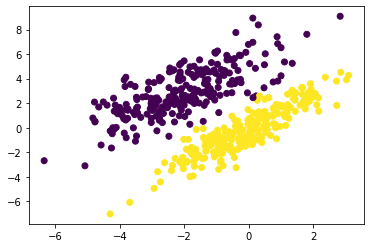

In [98]:
y_p[y_p < 0.5] = 0
y_p[y_p >= 0.5] = 1
plt.scatter(X[:,0],X[:,1],c=y_p)

### Sigmoid with cross entropy loss from pytorch

In [99]:
def train_loop_sigmdoid_2(X,y,loss_fn,lr=1e-3,n_epoch=500):
    w = torch.ones(3,requires_grad=True)
   # print(w)
    for i in range(n_epoch):
        if w.grad is not None:
            w.grad.zero_()

        y_p = model_sigmoid(X,w)
        l = loss_fn(y_p,y)
        l.backward()

        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l))

        w = (w - lr * w.grad)
        w.detach_()
        w.requires_grad_()

    return w

In [100]:
loss_bce = nn.BCELoss(reduction='sum')
w = train_loop_sigmdoid_2(X,y,loss_bce,lr=1e-4,n_epoch=5000)
y_p = model_sigmoid(X,w).detach()

Epoch 0, Loss 906.067566
Epoch 100, Loss 81.475182
Epoch 200, Loss 63.895813
Epoch 300, Loss 53.396957
Epoch 400, Loss 46.387581
Epoch 500, Loss 41.376038
Epoch 600, Loss 37.611336
Epoch 700, Loss 34.676220
Epoch 800, Loss 32.320824
Epoch 900, Loss 30.386578
Epoch 1000, Loss 28.768078
Epoch 1100, Loss 27.392475
Epoch 1200, Loss 26.207855
Epoch 1300, Loss 25.176163
Epoch 1400, Loss 24.268930
Epoch 1500, Loss 23.464348
Epoch 1600, Loss 22.745491
Epoch 1700, Loss 22.098986
Epoch 1800, Loss 21.514114
Epoch 1900, Loss 20.982214
Epoch 2000, Loss 20.496181
Epoch 2100, Loss 20.050146
Epoch 2200, Loss 19.639198
Epoch 2300, Loss 19.259220
Epoch 2400, Loss 18.906721
Epoch 2500, Loss 18.578720
Epoch 2600, Loss 18.272659
Epoch 2700, Loss 17.986324
Epoch 2800, Loss 17.717796
Epoch 2900, Loss 17.465410
Epoch 3000, Loss 17.227695
Epoch 3100, Loss 17.003353
Epoch 3200, Loss 16.791243
Epoch 3300, Loss 16.590355
Epoch 3400, Loss 16.399778
Epoch 3500, Loss 16.218714
Epoch 3600, Loss 16.046434
Epoch 3700, 

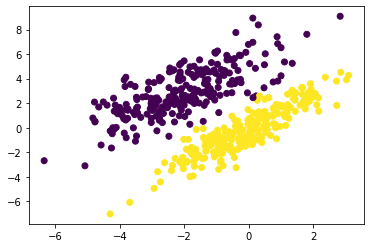

In [101]:
y_p[y_p < 0.5] = 0
y_p[y_p >= 0.5] = 1
plt.scatter(X[:,0],X[:,1],c=y_p)

### Softmax classification

generate testdata

C:\Users\dohr\AppData\Local\Temp\ipykernel_14896\3254666763.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)


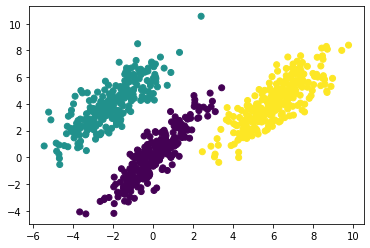

In [102]:
X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)
X2 = torch.tensor(np.random.multivariate_normal([-2,4],[[2,2],[2,3]],250)).type(torch.FloatTensor)
X3 = torch.tensor(np.random.multivariate_normal([6,4],[[2,2],[2,3]],250)).type(torch.FloatTensor)
X = torch.cat((X1,X2,X3),0)
y = torch.cat((torch.zeros(250),torch.ones(250),torch.ones(250)*2),0)

plt.scatter(X[:,0],X[:,1],c=y)

In [103]:
def model_softmax(X,w,bias=True):
    x_temp = torch.cat((torch.ones(X.shape[0]).unsqueeze(dim=1),X),dim=1)
    return torch.softmax(x_temp @ w.T,dim = 1)

def train_loop_softmax(X,y,optimizer, loss_fn,n_epoch=500):
#    w = torch.randn(3,3,requires_grad=True)

    for i in range(n_epoch):
        optimizer.zero_grad()

        w = optimizer.param_groups[0]['params'][0]

        y_p = model_softmax(X,w)
        l = loss_fn(y_p,y)
        l.backward()

        if i % 500 == 0:
            print('Epoch %d, Loss %f' % (i,l))

        optimizer.step()
    return w

In [104]:
y_one_hot = nn.functional.one_hot(y.type(torch.LongTensor),num_classes=3)
y_one_hot = y_one_hot.type(torch.FloatTensor)
loss_ce = nn.CrossEntropyLoss(reduction='sum')
w = torch.randn(3,3,requires_grad=True)
optimizer = optim.SGD([w],lr=1e-3)

In [105]:
w = train_loop_softmax(X,y_one_hot,optimizer,loss_ce,n_epoch=5000)


Epoch 0, Loss 871.981323
Epoch 500, Loss 666.514832
Epoch 1000, Loss 665.262695
Epoch 1500, Loss 664.802612
Epoch 2000, Loss 664.555176
Epoch 2500, Loss 664.398254
Epoch 3000, Loss 664.288940
Epoch 3500, Loss 664.207886
Epoch 4000, Loss 664.145264
Epoch 4500, Loss 664.095093


In [106]:
y_p = model_softmax(X,w)
y_c = y_p.argmax(dim=1)

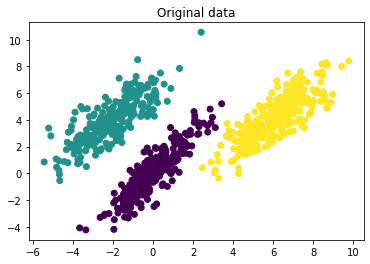

In [107]:
plt.title('Original data')
plt.scatter(X[:,0],X[:,1],c=y)

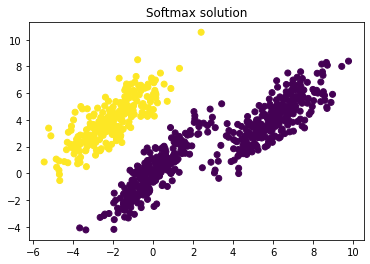

In [108]:
plt.title('Softmax solution')
plt.scatter(X[:,0],X[:,1],c=y_c)

## Example: aproximate sin(x)

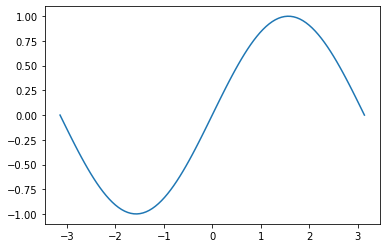

In [109]:
x = torch.linspace(-torch.pi,torch.pi,steps=100)
y = torch.sin(x)
plt.plot(x,y)

In [110]:
def train_loop_seq(X,y,model,optimizer, loss_fn,n_epoch=5000):
#    w = torch.randn(3,3,requires_grad=True)

    start = time.time()
    step = int(n_epoch/10)
    for i in range(n_epoch):
        optimizer.zero_grad()


        y_p = model(X)
        l = loss_fn(y_p,y)
        l.backward()

        if i % step == 0:
            print('Epoch %d, Loss %f' % (i,l))

        optimizer.step()
    end = time.time()
    print('------------------------------')
    print('training loop finished. ')
    print(f'training time: {end-start}')
    print('Loss: %f' % l)

x_t = x.unsqueeze(dim=1)
x_t.requires_grad_()
y_t = y.unsqueeze(dim=1)
loss_mse = nn.MSELoss()

### segential model 2x1250 + ReLU with 1500 epochs

In [111]:
seq_model = nn.Sequential(
    nn.Linear(1,1250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1250,1250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1250,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=1500)

Epoch 0, Loss 0.545209
Epoch 150, Loss 0.006748
Epoch 300, Loss 0.001994
Epoch 450, Loss 0.000879
Epoch 600, Loss 0.000488
Epoch 750, Loss 0.000310
Epoch 900, Loss 0.000214
Epoch 1050, Loss 0.000155
Epoch 1200, Loss 0.000118
Epoch 1350, Loss 0.000092
------------------------------
training loop finished. 
training time: 24.26665949821472
Loss: 0.000074


### seq model 2x1250 + Tanh

In [112]:
seq_model = nn.Sequential(
    nn.Linear(1,1250,bias=True),
    nn.Tanh(),
    nn.Linear(1250,1250,bias=True),
    nn.Tanh(),
    nn.Linear(1250,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=1500)

Epoch 0, Loss 0.674899
Epoch 150, Loss 0.007074
Epoch 300, Loss 0.005335
Epoch 450, Loss 0.004107
Epoch 600, Loss 0.003155
Epoch 750, Loss 0.002421
Epoch 900, Loss 0.002260
Epoch 1050, Loss 0.001607
Epoch 1200, Loss 0.001253
Epoch 1350, Loss 0.001382
------------------------------
training loop finished. 
training time: 25.292888402938843
Loss: 0.000932


### segential model 3x250 + ReLU with 2500 epochs

In [114]:
seq_model = nn.Sequential(
    nn.Linear(1,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=2500)

Epoch 0, Loss 0.498915
Epoch 250, Loss 0.022025
Epoch 500, Loss 0.004908
Epoch 750, Loss 0.001670
Epoch 1000, Loss 0.000754
Epoch 1250, Loss 0.000415
Epoch 1500, Loss 0.000256
Epoch 1750, Loss 0.000172
Epoch 2000, Loss 0.000122
Epoch 2250, Loss 0.000091
------------------------------
training loop finished. 
training time: 8.64895224571228
Loss: 0.000070


### segential model 4x250 + ReLU with 2500 epochs

In [115]:
seq_model = nn.Sequential(
    nn.Linear(1,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=2500)

Epoch 0, Loss 0.471498
Epoch 250, Loss 0.062047
Epoch 500, Loss 0.015255
Epoch 750, Loss 0.004610
Epoch 1000, Loss 0.001784
Epoch 1250, Loss 0.000853
Epoch 1500, Loss 0.000494
Epoch 1750, Loss 0.000326
Epoch 2000, Loss 0.000223
Epoch 2250, Loss 0.000163
------------------------------
training loop finished. 
training time: 11.761501789093018
Loss: 0.000122


### segential model 2x500 + ReLU with 2500 epochs

In [116]:
seq_model = nn.Sequential(
    nn.Linear(1,500,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(500,500,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(500,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=2500)

Epoch 0, Loss 0.404813
Epoch 250, Loss 0.006508
Epoch 500, Loss 0.004807
Epoch 750, Loss 0.003178
Epoch 1000, Loss 0.002010
Epoch 1250, Loss 0.001367
Epoch 1500, Loss 0.000964
Epoch 1750, Loss 0.000872
Epoch 2000, Loss 0.000625
Epoch 2250, Loss 0.000517
------------------------------
training loop finished. 
training time: 10.76262354850769
Loss: 0.000485


### segential model 10x100 + ReLU with 2500 epochs

In [117]:
seq_model = nn.Sequential(
    nn.Linear(1,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=2500)

Epoch 0, Loss 0.502470
Epoch 250, Loss 0.494945
Epoch 500, Loss 0.494888
Epoch 750, Loss 0.494835
Epoch 1000, Loss 0.494779
Epoch 1250, Loss 0.494711
Epoch 1500, Loss 0.494627
Epoch 1750, Loss 0.494518
Epoch 2000, Loss 0.494368
Epoch 2250, Loss 0.494149
------------------------------
training loop finished. 
training time: 11.199914455413818
Loss: 0.493829


## Example approximate sin(x) + noise

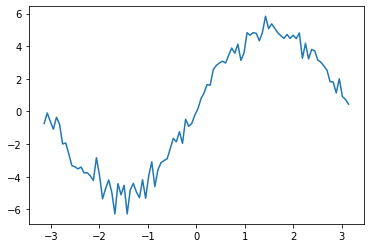

In [118]:
x = torch.linspace(-torch.pi,torch.pi,steps=100)
y = 5*torch.sin(x) + np.random.normal(0,0.5,100)
y = y.type(torch.FloatTensor)
x_t = x.unsqueeze(dim=1)
x_t.requires_grad_()
y_t = y.unsqueeze(dim=1)
plt.plot(x,y)

### segential model 2x1250 + ReLU with 1500 epochs

In [119]:
seq_model = nn.Sequential(
    nn.Linear(1, 1250, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1250, 1250, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1250, 1), )

optimizer = optim.SGD(seq_model.parameters(), lr=1e-2)
train_loop_seq(x_t, y_t, seq_model, optimizer, loss_mse, n_epoch=2500)

Epoch 0, Loss 13.493575
Epoch 250, Loss 1.633943
Epoch 500, Loss 1.066600
Epoch 750, Loss 0.818273
Epoch 1000, Loss 0.671951
Epoch 1250, Loss 0.568065
Epoch 1500, Loss 0.499002
Epoch 1750, Loss 0.450812
Epoch 2000, Loss 0.423363
Epoch 2250, Loss 0.397271
------------------------------
training loop finished. 
training time: 49.901508808135986
Loss: 0.367544


In [120]:
y.type()

'torch.FloatTensor'